In [80]:
import numpy as np
import pandas as pd
from gensim.models import Phrases
from gensim.corpora import Dictionary
from stop_words import get_stop_words
import tensorflow as tf
from keras import backend as K
from keras.models import Sequential, Model, load_model, save_model
from keras.layers import Dense
from keras.layers import LSTM, GRU, Conv1D, MaxPooling1D, Flatten
from keras.layers import GaussianNoise, BatchNormalization, Dropout
from keras.layers import Activation, Input, concatenate, Reshape, merge, dot
from keras.optimizers import Adam, RMSprop, SGD
from keras.regularizers import l1, l2
from keras.layers.embeddings import Embedding
from keras.preprocessing.sequence import skipgrams, make_sampling_table
from keras.callbacks import Callback, LambdaCallback, TensorBoard, ReduceLROnPlateau, EarlyStopping
from keras.utils import np_utils
from random import shuffle
import time
import pylab as pl
from ipywidgets import FloatProgress
from IPython import display
import matplotlib.pyplot as plt
%matplotlib notebook

In [65]:
# set backends of keras
sess = tf.Session(config=tf.ConfigProto(intra_op_parallelism_threads=8))
K.set_session(sess)

In [14]:
def is_desired_letter(char):
    order = ord(char)
    return order >= 97 and order < 123 or order >= 48 and order < 58 or order == ord(" ") or order == ord("'")


def get_text_data():
    # load the dataset but only keep the top n words, zero the rest
    train_data = pd.read_csv("input/kickstarter_train.csv")
    # remove symbols in each description
    train_data["desc"] = [[char for char in str(text).lower() if is_desired_letter(char)] for
                          text in train_data["desc"]]
    train_data["desc"] = [''.join(text).split() for text in train_data["desc"]]
    # remove too short desc
    drop_index = []
    for i in range(len(train_data)):
        if len(train_data.iloc[i, 2]) <= 8:
            drop_index.append(i)
    train_data.drop(train_data.index[drop_index])
    # get descriptions data
    train_texts = np.array(train_data.iloc[:, 2])

    return train_texts

In [40]:
# get training texts from disk
train_texts = get_text_data()
print("data grabbed")

data grabbed


In [41]:
# remove stop_words
def remove_stop_words(texts):
    stop_words = get_stop_words('en')
    stop_words.extend(["of", "with", "without", "and", "or", "the", "a"])
    texts = [[word for word in text if not word in stop_words and len(word)>1] for text in texts]
    return texts

# train bigram phrases
# min_count 15, threshold 0.8, scorer 'npmi', max_vocab_size 50000 seems great
bigram = Phrases(sentences=remove_stop_words(train_texts), scoring='npmi', min_count=15, threshold=0.8, max_vocab_size=50000)
print("bigram vocabulary size: ", len(bigram.vocab))
bigram.vocab.items()

bigram vocabulary size:  14930


dict_items([(b'box_plugs', 1), (b'can_design', 1), (b'modern_designs', 1), (b'hairline', 1), (b'shot_digital', 1), (b'art_sushi', 1), (b'hurting', 1), (b'donate', 252), (b'world_monsters', 1), (b'variety_colors', 1), (b'jonathan', 42), (b'next_hit', 1), (b'industry', 378), (b'emerging_label', 1), (b'ad', 45), (b'rhode', 1), (b'must_venture', 1), (b'ventures', 1), (b'looking_buy', 1), (b'software', 332), (b'man_lives', 1), (b'english', 250), (b'song_just', 1), (b'doctor_finds', 1), (b'struggles_make', 1), (b'vengeful', 1), (b'lead_path', 1), (b'gear_improve', 1), (b'simplified', 1), (b'community', 1904), (b'blood', 164), (b'compilation', 173), (b'anticipated_2015', 1), (b'magical_world', 1), (b'sophomore', 98), (b'sound', 735), (b'evolving', 1), (b'package_arrives', 1), (b'hello_dolly', 1), (b'third_album', 61), (b'lyrics', 168), (b'journey_final', 1), (b'killing', 79), (b'book_funnier', 1), (b'will_transform', 1), (b'allow', 270), (b'season_neighborhoods', 1), (b'cuisine', 1), (b'want_

In [42]:
# get dictionary of word with fair frequency
dictionary = Dictionary(documents=bigram[train_texts])
dictionary.filter_extremes(no_below=8)
dictionary.compactify()
n_vacab = len(dictionary.token2id)
print("dictionary vocabulary length:", n_vacab)

/Users/andywu/anaconda3/envs/tensorflow/lib/python3.5/site-packages/gensim/models/phrases.py:316: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


dictionary vocabulary length: 13410


In [43]:
# tokenize the texts and remove too short texts
train_texts = bigram[train_texts]
train_texts = [[dictionary.token2id[word] for word in text if word in dictionary.token2id] for text in train_texts]
train_texts = [text for text in train_texts if len(text) > 4]
print("tokenizing is done")
print("left texts num is: ", len(train_texts))
t = np.array([len(text) for text in train_texts])
print("The max len is {}, the average len is {}, the min len is {}".format(t.max(), t.mean(), t.min()))

/Users/andywu/anaconda3/envs/tensorflow/lib/python3.5/site-packages/gensim/models/phrases.py:316: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


tokenizing is done
left texts num is:  106691
The max len is 32, the average len is 16.562277980335736, the min len is 5


In [ ]:
# generate and save training data
# generate progress bar
f = FloatProgress(min=0, max=100)
display.display(f)
# load training data
training_pairs = []
training_labels = []
shuffle(train_texts)
for i, text in enumerate(train_texts):
    pairs, labels = skipgrams(sequence=text, vocabulary_size=n_vacab, negative_samples=1.)
    pairs = [np.array(x) for x in zip(*pairs)]
    if len(training_pairs) == 0:
        training_pairs = pairs
        training_labels = labels
    else:
        training_pairs = [np.append(training_pairs[0], pairs[0]), np.append(training_pairs[1], pairs[1])]
        training_labels = np.append(training_labels, labels)
    f.value = 100 * float(i)/float(len(train_texts))

# save the loaded file to file
np.savez("training pairs and labels.npz", target=training_pairs[0], context=training_pairs[1], labels=training_labels)
training_pairs_labels = np.load("training pairs and labels.npz")
training_pairs = [training_pairs_labels['target'], training_pairs_labels['context']]
training_labels = training_pairs_labels['labels']
print("preparing training data is done")

A Jupyter Widget

In [72]:
np.savez("training pairs and labels.npz", target=training_pairs[0], context=training_pairs[1], labels=training_labels)

In [71]:
# create embedding model
vec_dim = 64
embedding_layer = Embedding(input_dim=n_vacab, output_dim=vec_dim, input_length=1, name='embedding')
input_target = Input((1,))
input_context = Input((1,))
target = embedding_layer(input_target)
context = embedding_layer(input_context)
# generate similarity model output
similarity = dot([target, context], normalize=True, axes=2)
similarity = Reshape((1,))(similarity)
# generate training model output
dot_product = dot([target, context], axes=2)
dot_product = Reshape((1,), input_shape=(1, 1))(dot_product)
output = Activation("sigmoid")(dot_product)

# generate training and checking models
training_model = Model(inputs=[input_target, input_context], output=output)
similarity_model = Model(inputs=[input_target, input_context], output=similarity)

# compile for training
training_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# print model summary
print("summary for training_model:", training_model.summary())
print("summary for similarity_model:", similarity_model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
input_14 (InputLayer)           (None, 1)            0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 64)        858240      input_13[0][0]                   
                                                                 input_14[0][0]                   
__________________________________________________________________________________________________
dot_12 (Dot)                    (None, 1, 1)         0           embedding[0][0]                  
          

/Users/andywu/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:17: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("ac..., inputs=[<tf.Tenso...)`
/Users/andywu/anaconda3/envs/tensorflow/lib/python3.5/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("re..., inputs=[<tf.Tenso...)`


In [85]:
# train embedding
# load train data from file
training_pairs_labels = np.load("training pairs and labels.npz")
training_pairs = [training_pairs_labels['target'], training_pairs_labels['context']]
training_labels = training_pairs_labels['labels']
print(training_pairs[0].shape)
print(training_labels.shape)
# train the model
training_model.fit(training_pairs, training_labels, epochs=5, batch_size=256, shuffle=True, 
                  verbose=1, validation_split=0.01, callbacks=[ReduceLROnPlateau(), EarlyStopping(patience=1)])

# save to file
filepath = "embedding_layer_acc:{}.h5".format(loss[1])
training_model.save_weights(filepath)

[   29  3051  7300   888  9379   931  9434 10353  1388 10188   988  1848
 10281  3588  8811  7878  1550  7996 11949  1500]
(2640,)


ValueError: Input arrays should have the same number of samples as target arrays. Found 20 input samples and 2640 target samples.

In [53]:
filepath = "embedding_layer_acc:{}.h5".format(loss[1])
training_model.save_weights(filepath)

In [38]:
index_target = np.random.randint(n_vacab)
dictionary.get(index_target)
target = np.array([index_target]*(n_vacab))
match = np.array(range(n_vacab))
result = similarity_model.predict_on_batch([target, match])
result = sorted(enumerate([item for item_0 in result for item_1 in item_0 for item in item_1]), key=lambda x: -x[1])
print("for word: {}, the best similarities are: ".format(dictionary.get(index_target)))
for i in range(10):
    print(dictionary.get(result[i][0]), end=' ')

TypeError: 'numpy.float32' object is not iterable

<IPython.core.display.Javascript object>


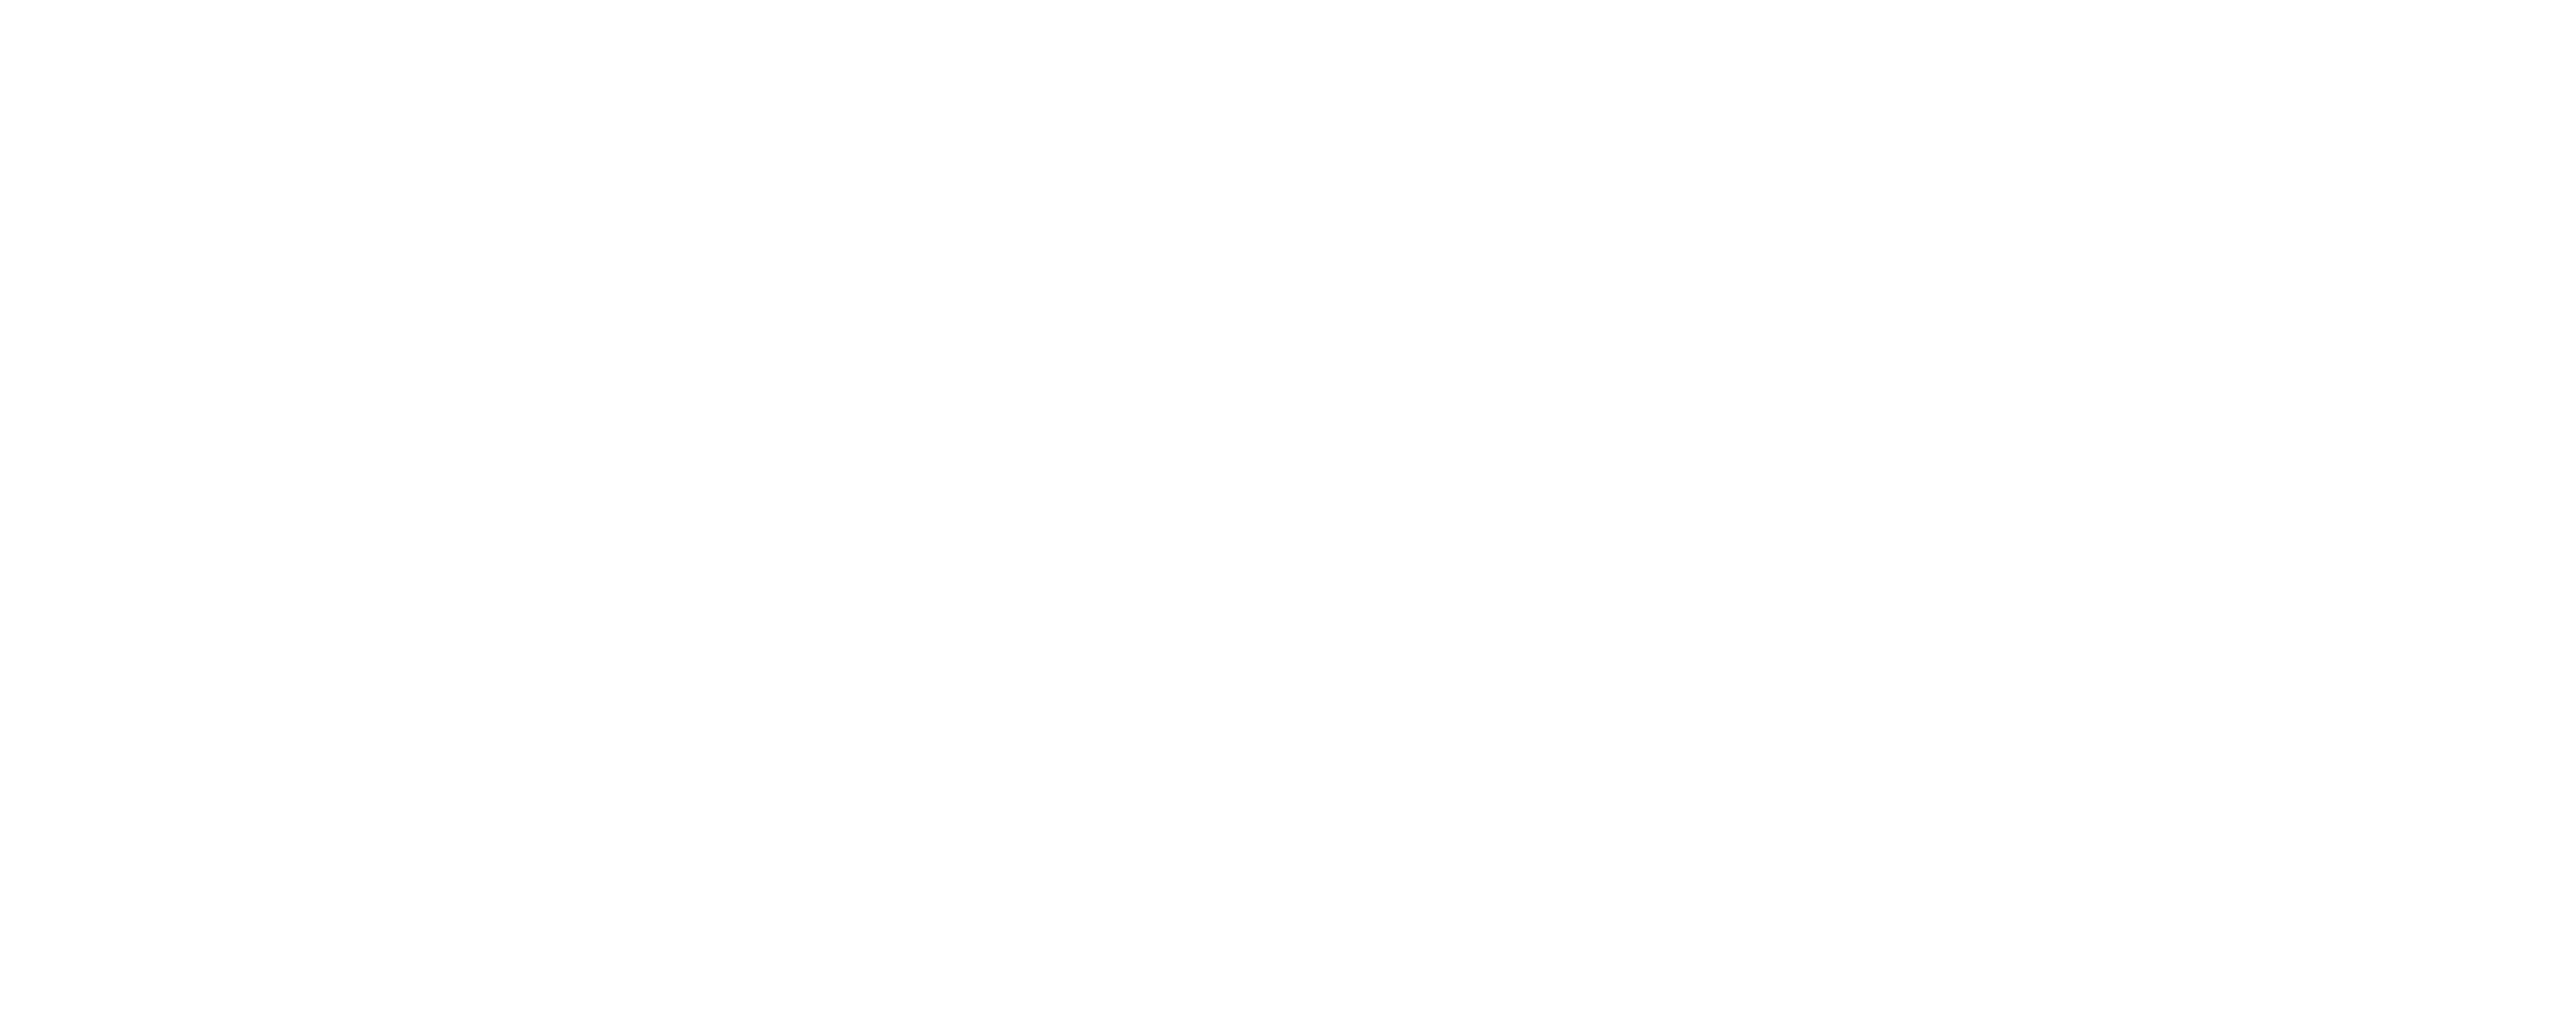

ValueError: Input arrays should have the same number of samples as target arrays. Found 125424 input samples and 1271448 target samples.

In [67]:
# valuable example of training on batches manully
# train embedding and plot loss realtime
# turn on interactive plotting
fig, (ax1, ax2) = plt.subplots(2,1, sharex=True)
fig.set_size_inches(20, 8)
# start epochs of training
for iteration in range(5):
    i = 0
    x = []
    y1 = []
    y2 = []
    shuffle(train_texts)
    batch_size = [128, 256, 256, 512, 1024]
    for text in train_texts:
        i += 1
        # concantenate all the pairs of input every 256 and feed to the train_on_batch to boost training efficiency
        if i % batch_size[iteration] == 0: 
            for j in range(20):
                loss = training_model.train_on_batch(training_pairs, training_labels)
                # plot the result dynamically
                if len(x) > 10:
                    x.pop(0)
                    y1.pop(0)
                    y2.pop(0)
                x.append(i)
                y1.append(loss[0])
                y2.append(loss[1])
                ax1.plot(x, y1, '-r')
                ax2.plot(x, y2, '-b')
                fig.canvas.draw()
                time.sleep(0.05)
                print(loss)
            training_pairs = []
            labels = []
        else: 
            pairs, labels = skipgrams(sequence=text, vocabulary_size=n_vacab, negative_samples=3.)
            pairs = [np.array(x) for x in zip(*pairs)]
            labels = np.array(labels)
            if len(training_pairs) == 0:
                training_pairs = pairs
                training_labels = labels
            else:
                training_pairs = [np.append(training_pairs[0], pairs[0]), np.append(training_pairs[1], pairs[1])]
                training_labels = np.append(training_labels, labels)
    print("{} epoch finished".format(i))
    # save check point
    filepath = "embedding_layer_acc:{}.h5".format(loss[1])
    training_model.save_weights(filepath)